# Exploratory Data Analysis ENEM2019 v1.0

This notebook will contain an exploratory data analysis (EDA) of ENEM2019 (last year before COVID-19) dataset, one of the most important steps in any data science project. The goal of this notebook is to provide a quick overview of the data and the methods used to explore it. 

## 1. Imports

In [10]:
import pandas as pd
import os 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

pd.set_option('display.max_columns', None)
sns.set_palette('Paired')
sns.set_style("whitegrid")
plt.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['font.size'] = 14

## 2. Reading Data

In [11]:
processed_directory = sorted(filter(lambda dir: '.parquet' in dir, os.listdir('../data/processed')), reverse = True)[0]
processed_directory = '../data/processed/' + processed_directory

data = pd.read_parquet(processed_directory).query('enem_year == 2019')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15629 entries, 16939 to 32567
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           15629 non-null  int64  
 1   enem_year                    15629 non-null  int64  
 2   age                          15629 non-null  object 
 3   sex                          15629 non-null  object 
 4   marital_status               15629 non-null  object 
 5   color_race                   15629 non-null  object 
 6   high_school_status           15629 non-null  object 
 7   year_completion_high_school  15629 non-null  int64  
 8   school_type                  15629 non-null  object 
 9   id_city_school               3439 non-null   float64
 10  city_school                  3439 non-null   object 
 11  state_school                 3439 non-null   object 
 12  id_city_test                 15629 non-null  int64  
 13  city_test   

In [12]:
data.head(5)

,id,enem_year,age,sex,marital_status,color_race,high_school_status,year_completion_high_school,school_type,id_city_school,city_school,state_school,id_city_test,city_test,state_test,presence_day_1,presence_day_2,nature_science_score,human_sciences_score,languages_codes_score,mathematics_score,ortography_score,understanding_score,structuring_score,argumentation_score,proposal_score,redaction_score,father_schooling,mother_schooling,father_profession_group,mother_profession_group,family_members,family_income,bedrooms_qty,cars_qty,television_qty,phones_qty,computer_qty,internet_access
16939,190001004902,2019,21 years-old,F,Single,Brown,Completed High School,3,Unknown,NaN,None,None,1506807,Santarem,PA,1.0,1.0,450.5,481.3,488.4,438.8,80.0,120.0,120.0,100.0,100.0,520.0,Didn't complete Elementary School,Completed High School,Group A,Group A,4,Less than 1 minimum wage,One,No,One,One,No,Yes
16940,190001005610,2019,Between 26 and 30 years-old,F,Single,Brown,Completed High School,10,Unknown,NaN,None,None,1500800,Ananindeua,PA,1.0,1.0,576.7,609.5,596.2,606.2,160.0,180.0,160.0,180.0,160.0,840.0,Completed High School,Completed College,Group B,Group D,2,Between 3-4 minimum wages,Two,No,Two,Two,One,Yes
16941,190001006229,2019,18 years-old,F,Single,Brown,Completed High School,1,Unknown,NaN,None,None,1500800,Ananindeua,PA,1.0,1.0,514.4,575.0,566.2,392.8,120.0,140.0,120.0,160.0,180.0,720.0,Unknown,Completed High School,Group F,Group A,2,Less than 1 minimum wage,Three,No,One,Two,No,No
16942,190001006473,2019,18 years-old,F,Single,Brown,Completed High School,1,Unknown,NaN,None,None,1506203,Salinopolis,PA,1.0,1.0,429.6,566.0,562.9,373.3,120.0,120.0,120.0,180.0,40.0,580.0,Completed Elementary School,Completed College,Group C,Group C,3,No income,Two,No,One,Three,No,No
16943,190001006565,2019,18 years-old,M,Single,Black,Ends in the current year,0,Public,1501303.0,Barcarena,PA,1501303,Barcarena,PA,1.0,1.0,507.9,532.8,527.0,439.4,160.0,200.0,180.0,200.0,200.0,940.0,Never studied,Didn't complete Elementary School,Group A,Group B,5,Between 1-1.5 minimum wages,Two,No,One,Two,No,No


## 3. Exploratory Data Analysis

### 3.1 Check NULL Values

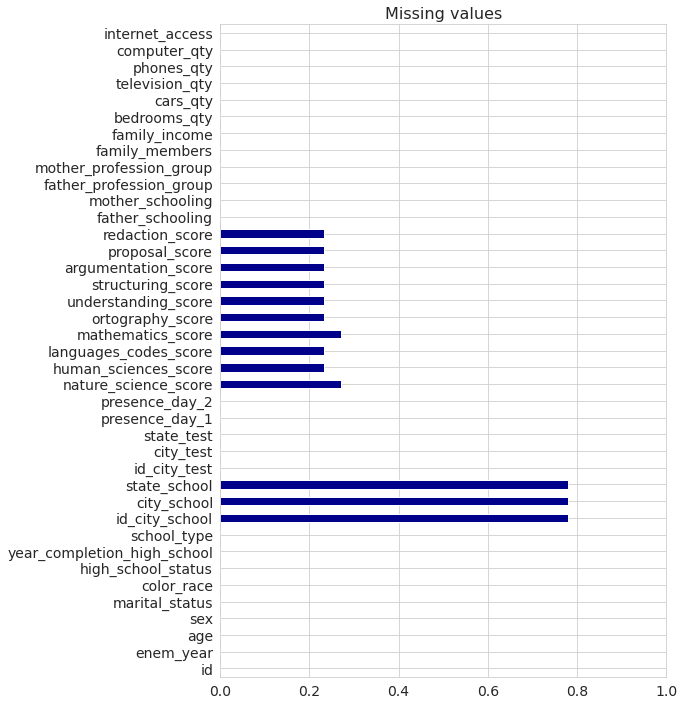

In [13]:
(data.isna().sum() / data.shape[0]).plot.barh(figsize = (8, 12), color = 'darkblue')

plt.title('Missing values', fontsize = 16)
plt.xlim(0, 1.0)
plt.savefig('../reports/figures/1.0-exploratory-data-analysis-enem2019/missing_values.jpeg', bbox_inches = 'tight', dpi = 600) 
plt.show()

The dataset has a lot of missing values. Especially in score data and id_city_school. In the first case, it occurs because the score data is not filled if the student didn't take the test. In the second case, seems that is mandatory to fill this field only the candidates that high_school_status is equal to "Ends in the current year".

*  The id_city_school will be removed from the dataset because it is not useful for the modelling;
*  The candidates that have null values in score data will be removed from the dataset;

### 3.2 Missed Candidates

### 3.2.1 By Family Income

In [14]:
# ordered labels

income_order = [
  'No income',
  'Less than 1 minimum wage',
  'Between 1-1.5 minimum wages',
  'Between 1.5-2 minimum wages',
  'Between 2-2.5 minimum wages',
  'Between 2.5-3 minimum wages',
  'Between 3-4 minimum wages',
  'Between 4-5 minimum wages',
  'Between 5-6 minimum wages',
  'Between 6-7 minimum wages',
  'Between 7-8 minimum wages',
  'Between 8-9 minimum wages',
  'Between 9-10 minimum wages',
  'Between 10-12 minimum wages',
  'Between 12-15 minimum wages',
  'Between 15-20 minimum wages',
  'More than 20 minimum wages'
]

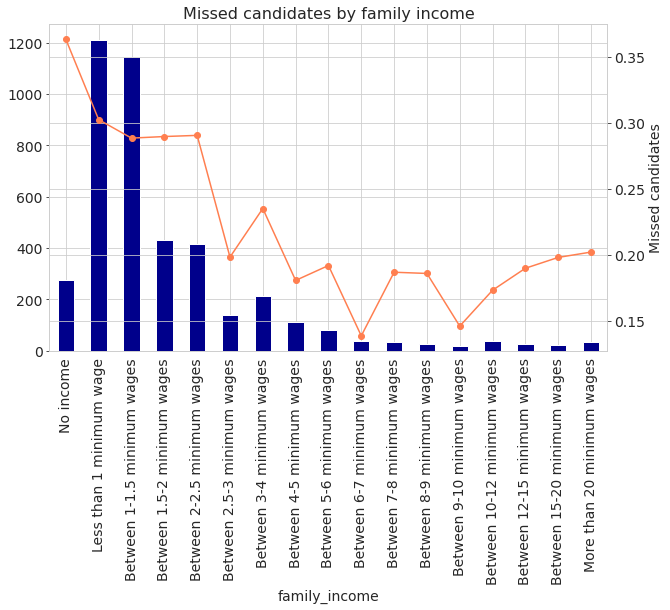

In [15]:
# missed in either first or second day of test
missed_candidates = data.query('(presence_day_1 + presence_day_2) != 2')

# grouping by family income
missed_candidates_family_income = missed_candidates.groupby('family_income').size()[income_order]
total_candidates = data.groupby('family_income').size()[income_order]

# count of missed candidates
bar_plot = missed_candidates_family_income.plot.bar(figsize = (8, 6), color = 'darkblue')

# relative missed candidates
line_plot = bar_plot.twinx()
(missed_candidates_family_income / total_candidates).plot(figsize = (10, 6), color = 'coral', marker = 'o', ax = line_plot)

plt.title('Missed candidates by family income', fontsize = 16)
plt.ylabel('Missed candidates')
plt.savefig('../reports/figures/1.0-exploratory-data-analysis-enem2019/missed_candidates_by_family_income.jpeg', bbox_inches = 'tight', dpi = 600)
plt.show()

### 3.2.2 By Color and Race

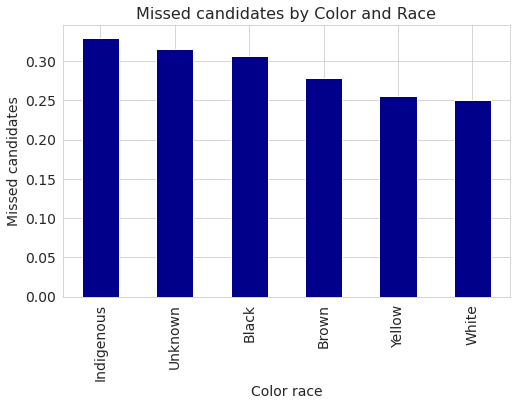

In [16]:
missed_candidates_color_race = missed_candidates.groupby('color_race').size()
total_candidates = data.groupby('color_race').size()

# count of missed candidates
bar_plot = (missed_candidates_color_race / total_candidates).sort_values(ascending = False).plot.bar(figsize = (8, 5), color = 'darkblue')

plt.title('Missed candidates by Color and Race', fontsize = 16)
plt.xlabel('Color race')
plt.ylabel('Missed candidates')
plt.savefig('../reports/figures/1.0-exploratory-data-analysis-enem2019/missed_candidates_by_color_race.jpeg', bbox_inches = 'tight', dpi = 600)
plt.show()

### 3.2.3 By State

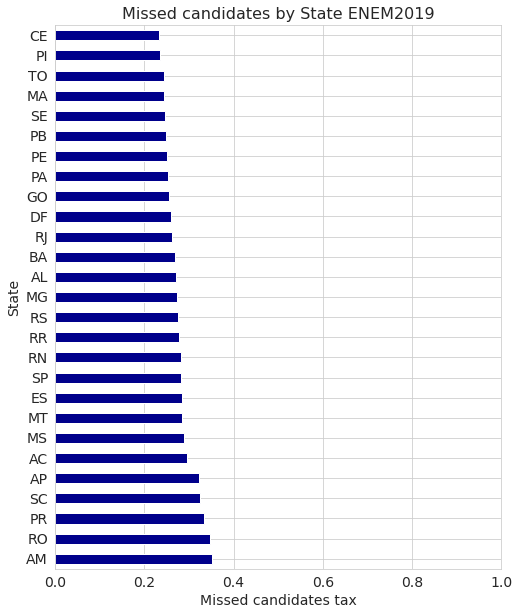

In [17]:
missed_candidates_state_test = missed_candidates.groupby('state_test').size()
total_candidates = data.groupby('state_test').size()

# count of missed candidates
bar_plot = (missed_candidates_state_test / total_candidates).sort_values(ascending = False).plot.barh(figsize = (8, 10), color = 'darkblue')

plt.title('Missed candidates by State ENEM2019', fontsize = 16)
plt.xlabel('Missed candidates tax')
plt.ylabel('State')
plt.xlim(0, 1.0)
plt.savefig('../reports/figures/1.0-exploratory-data-analysis-enem2019/missed_candidates_by_state.jpeg', bbox_inches = 'tight', dpi = 600)
plt.show()

As we can see in the two graphs above, the candidates that live nearby the Amazônia Forest (in the North: AM and RO states) have more difficulty attending the test:
* In the first graph (3.2.2), AM contains more candidates that live near the Amazônia Forest, tagged as (Indigenous color and race);
* In the second graph (3.2.3), AM and RO have 

### 3.2.4 By School Type

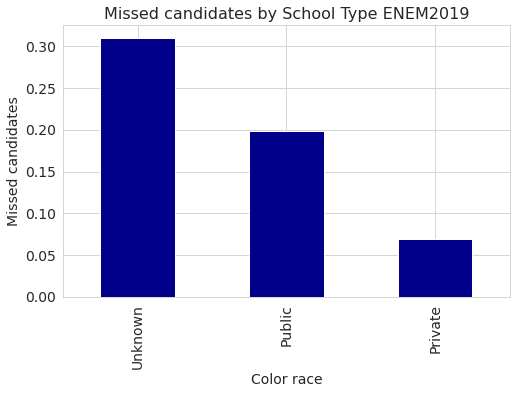

In [18]:
missed_candidates_school_type = missed_candidates.groupby('school_type').size()
total_candidates = data.groupby('school_type').size()

# count of missed candidates
bar_plot = (missed_candidates_school_type / total_candidates).sort_values(ascending = False).plot.bar(figsize = (8, 5), color = 'darkblue')

plt.title('Missed candidates by School Type ENEM2019', fontsize = 16)
plt.xlabel('Color race')
plt.ylabel('Missed candidates')
plt.savefig('../reports/figures/1.0-exploratory-data-analysis-enem2019/missed_candidates_by_school_type.jpeg', bbox_inches = 'tight', dpi = 600)
plt.show()

### 3.2.5 By Sex

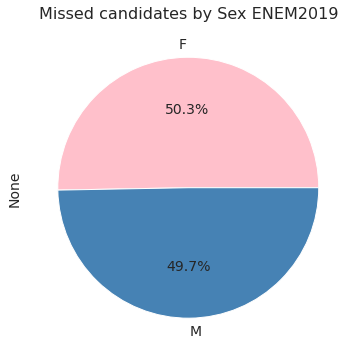

In [19]:
missed_candidates_sex = missed_candidates.groupby('sex').size()
total_candidates = data.groupby('sex').size()

# count of missed candidates
bar_plot = (missed_candidates_sex / total_candidates).plot.pie(figsize = (6, 6), autopct = '%1.1f%%', colors = ['pink', 'steelblue'])

plt.title('Missed candidates by Sex ENEM2019', fontsize = 16)
plt.xlabel(None)
plt.savefig('../reports/figures/1.0-exploratory-data-analysis-enem2019/missed_candidates_by_sex.jpeg', bbox_inches = 'tight', dpi = 600)
plt.show()

### 3.3 School Type Distribution

In [20]:
# filter out candidates that failed in ENEM in one of the two days
# each presence day has value 1 then (presence_day_1 + presence_day_2) is equal 2
present_candidates = data.query('(presence_day_1 + presence_day_2) == 2')
present_candidates.head(5)

,id,enem_year,age,sex,marital_status,color_race,high_school_status,year_completion_high_school,school_type,id_city_school,city_school,state_school,id_city_test,city_test,state_test,presence_day_1,presence_day_2,nature_science_score,human_sciences_score,languages_codes_score,mathematics_score,ortography_score,understanding_score,structuring_score,argumentation_score,proposal_score,redaction_score,father_schooling,mother_schooling,father_profession_group,mother_profession_group,family_members,family_income,bedrooms_qty,cars_qty,television_qty,phones_qty,computer_qty,internet_access
16939,190001004902,2019,21 years-old,F,Single,Brown,Completed High School,3,Unknown,NaN,None,None,1506807,Santarem,PA,1.0,1.0,450.5,481.3,488.4,438.8,80.0,120.0,120.0,100.0,100.0,520.0,Didn't complete Elementary School,Completed High School,Group A,Group A,4,Less than 1 minimum wage,One,No,One,One,No,Yes
16940,190001005610,2019,Between 26 and 30 years-old,F,Single,Brown,Completed High School,10,Unknown,NaN,None,None,1500800,Ananindeua,PA,1.0,1.0,576.7,609.5,596.2,606.2,160.0,180.0,160.0,180.0,160.0,840.0,Completed High School,Completed College,Group B,Group D,2,Between 3-4 minimum wages,Two,No,Two,Two,One,Yes
16941,190001006229,2019,18 years-old,F,Single,Brown,Completed High School,1,Unknown,NaN,None,None,1500800,Ananindeua,PA,1.0,1.0,514.4,575.0,566.2,392.8,120.0,140.0,120.0,160.0,180.0,720.0,Unknown,Completed High School,Group F,Group A,2,Less than 1 minimum wage,Three,No,One,Two,No,No
16942,190001006473,2019,18 years-old,F,Single,Brown,Completed High School,1,Unknown,NaN,None,None,1506203,Salinopolis,PA,1.0,1.0,429.6,566.0,562.9,373.3,120.0,120.0,120.0,180.0,40.0,580.0,Completed Elementary School,Completed College,Group C,Group C,3,No income,Two,No,One,Three,No,No
16943,190001006565,2019,18 years-old,M,Single,Black,Ends in the current year,0,Public,1501303.0,Barcarena,PA,1501303,Barcarena,PA,1.0,1.0,507.9,532.8,527.0,439.4,160.0,200.0,180.0,200.0,200.0,940.0,Never studied,Didn't complete Elementary School,Group A,Group B,5,Between 1-1.5 minimum wages,Two,No,One,Two,No,No


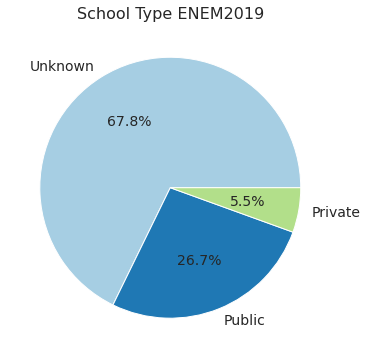

In [21]:
present_candidates.school_type.value_counts().plot.pie(figsize = (6, 6), autopct = '%1.1f%%')

plt.title('School Type ENEM2019', fontsize = 16)
plt.ylabel(None)
plt.savefig('../reports/figures/1.0-exploratory-data-analysis-enem2019/school_type_all_candidates.jpeg', bbox_inches = 'tight', dpi = 600)
plt.show()

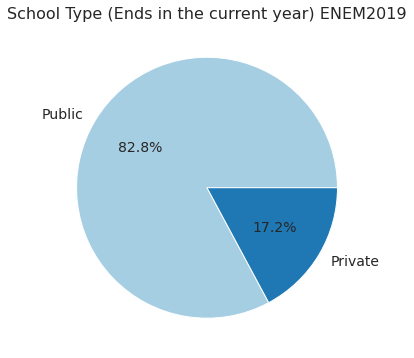

In [22]:
present_candidates.query('high_school_status == "Ends in the current year"').school_type.value_counts().plot.pie(figsize = (6, 6), autopct = '%1.1f%%')

plt.title('School Type (Ends in the current year) ENEM2019', fontsize = 16)
plt.ylabel(None)
plt.savefig('../reports/figures/1.0-exploratory-data-analysis-enem2019/school_type_ends_current_year.jpeg', bbox_inches = 'tight', dpi = 600)
plt.show()

As explained in the previous observation, the school_type variable is filled just if the student is a high school student. The majority of the candidates study in public high schools.

### 3.4 Sex Distribution


#### 3.4.1 All dataset

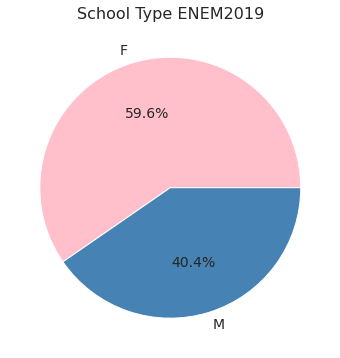

In [23]:
data.sex.value_counts().plot.pie(figsize = (6, 6), autopct = '%1.1f%%', colors = ['pink', 'steelblue'])

plt.title('School Type ENEM2019', fontsize = 16)
plt.ylabel(None)
plt.savefig('../reports/figures/1.0-exploratory-data-analysis-enem2019/school_type_sex.jpeg', bbox_inches = 'tight', dpi = 600)
plt.show()

Most candidates in our dataset are women but don't have a big difference between these two classes.

#### 3.4.2 Presents By Family Income

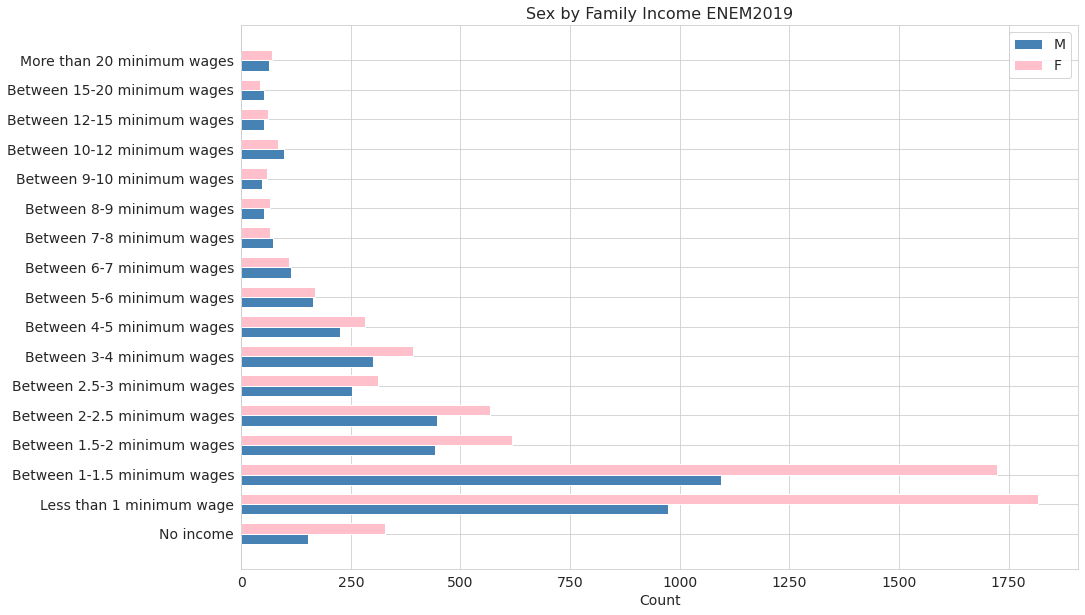

In [24]:
sex_family_income_presents = present_candidates.groupby(['family_income', 'sex']).size()[income_order]

# number of men and women splited
men = sex_family_income_presents.loc[(income_order, 'M')].values
women = sex_family_income_presents.loc[(income_order, 'F')].values

fig, ax = plt.subplots(figsize = (15, 10))
men_bars = ax.barh(np.arange(len(income_order)) - 0.35 / 2, men, 0.35, label = 'M', color = 'steelblue')
women_bars = ax.barh(np.arange(len(income_order)) + 0.35 / 2, women, 0.35, label = 'F', color = 'pink')

# plot labels
ax.set_title('Sex by Family Income ENEM2019', fontsize = 16)
ax.set_xlabel('Count')
ax.legend()

# seting the income in y ticks
ax.set_yticks(np.arange(len(income_order)), income_order)

plt.savefig('../reports/figures/1.0-exploratory-data-analysis-enem2019/present_candidates_sex_family_income.jpeg', bbox_inches = 'tight', dpi = 600)
plt.show()

There is a high concentration of female candidates with low family income. But as we can see, how much bigger the income family, the more the difference between the gender decrease.

## 3.4 Cities and States Distribution

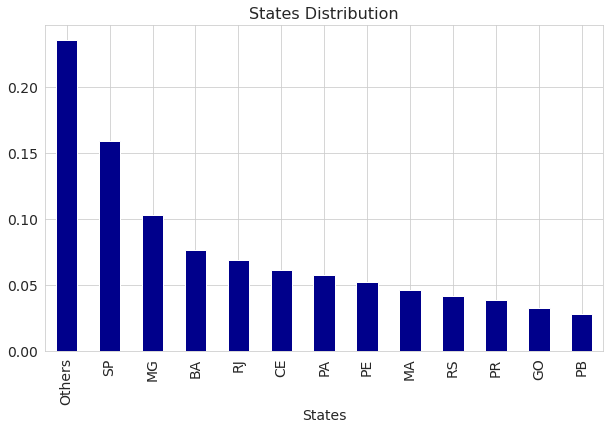

In [25]:
less_frequent = present_candidates.state_test.value_counts().tail(15)

less_to_others = {state: 'Others' for state in less_frequent.index}
present_candidates.state_test.replace(less_to_others).value_counts(normalize = True).plot.bar(figsize = (10, 6), color = 'darkblue')

plt.title('States Distribution', fontsize = 16)
plt.xlabel('States')
plt.ylabel(None)
plt.savefig('../reports/figures/1.0-exploratory-data-analysis-enem2019/states-distribution.jpeg', bbox_inches = 'tight', dpi = 600)
plt.show()

### 3.4.3 School and Test Cities

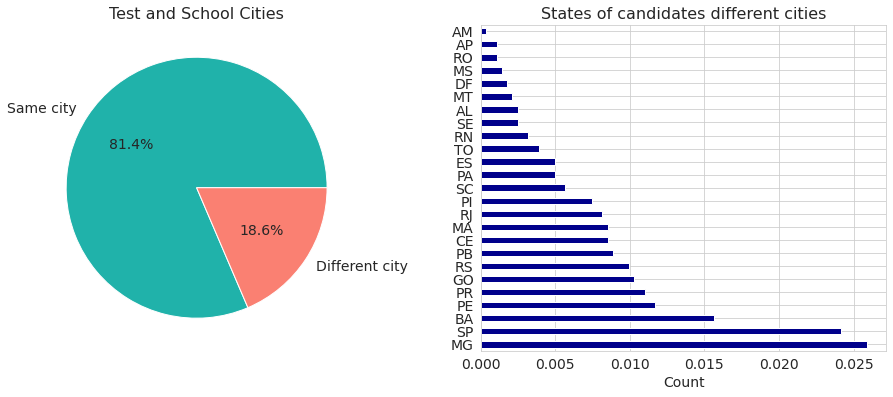

In [26]:
fig, ax = plt.subplots(1, 2, figsize = (16, 6))

# remove some candidates that don't have city school
school_test_city = present_candidates[present_candidates.city_school.notnull()]

# pie plot
school_test_city.eval('city_school == city_test').replace({
    True: 'Same city', 
    False: 'Different city'
}).value_counts().plot.pie(autopct = '%1.1f%%', colors = ['lightseagreen', 'salmon'], ax = ax[0])
ax[0].set_title('Test and School Cities', fontsize = 16)
ax[0].set_ylabel(None)

# barh plot
(school_test_city.query('city_school != city_test').state_school.value_counts()/school_test_city.shape[0]).plot.barh(color = 'darkblue', ax = ax[1])
ax[1].set_title('States of candidates different cities', fontsize = 16)
ax[1].set_xlabel('Count')

plt.savefig('../reports/figures/1.0-exploratory-data-analysis-enem2019/school_test_same_city.jpeg', bbox_inches = 'tight', dpi = 600)
plt.show()

Most of the candidates present take the test in the same city where they live. In the right graph we can notice that MG state have the major candidates that take the test in different city.